In [2]:
!pip install opencv-python numba numpy matplotlib requests

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached numba-0.62.1-cp313-cp313-win_amd64.whl.metadata (2.9 kB)
  Using cached numpy-2.2.6-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached llvmlite-0.45.1-cp313-cp313-win_amd64.whl.metadata (5.0 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Using cached numpy-2.2.6-cp313-cp313-win_amd64.whl (12.6 MB)
Using cached numba-0.62.1-cp313-cp313-win_amd64.whl (2.7 MB)
Using cached llvmlite-0.45.1-cp313-cp313-win_amd64.whl (38.1 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 2.3.3

   ---------------------------------------- 0/4 [numpy]
    Uninstalling numpy-2.3.3:
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
      Successfully uninstalled numpy-2.3.3
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
   -----------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# === IMPORTAR LIBRERÍAS ===
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import requests

In [2]:
# === CREAR CARPETA LOCAL ===
carpeta = "imagenes"
os.makedirs(carpeta, exist_ok=True)

In [9]:
# Descargar 250 imágenes desde picsum.photos (muy estable para pruebas)
import os, time, requests
from PIL import Image
from io import BytesIO

carpeta = r"C:\Users\jeyco\Documents\GitHub\FiltradoEspacio\images\imagenes"
os.makedirs(carpeta, exist_ok=True)

total = 250
headers = {"User-Agent": "Test-Agent"}

for i in range(1, total + 1):
    try:
        # picsum permite pasar un seed para obtener imagenes distintas
        url = f"https://picsum.photos/400/400?random={i}"
        resp = requests.get(url, headers=headers, timeout=15)
        content_type = resp.headers.get('Content-Type', '').lower()
        if not content_type.startswith('image/'):
            print(f"[{i}] Content-Type inesperado: {content_type} (saltando)")
            continue

        # Determinar extensión desde content-type
        ext = '.jpg'
        if 'png' in content_type:
            ext = '.png'
        elif 'webp' in content_type:
            ext = '.webp'

        ruta = os.path.join(carpeta, f"foto_{i}{ext}")

        # Validar con PIL antes de guardar
        from io import BytesIO
        try:
            im = Image.open(BytesIO(resp.content))
            im.verify()
        except Exception as e:
            print(f"[{i}] Imagen inválida ({e}), reintentando en 0.5s")
            time.sleep(0.5)
            # reintentar una sola vez
            resp = requests.get(url, headers=headers, timeout=15)
            try:
                im = Image.open(BytesIO(resp.content))
                im.verify()
            except Exception as e2:
                print(f"[{i}] Falló nuevamente: {e2}. Se salta esta imagen.")
                continue

        with open(ruta, 'wb') as f:
            f.write(resp.content)
        print(f"[{i}/{total}] Guardada -> {ruta}")

        time.sleep(0.15)  # espera corta entre solicitudes

    except requests.RequestException as e:
        print(f"[{i}] Error de red: {e} (se salta)")

print("✅ Descarga completa (picsum).")


KeyboardInterrupt: 

In [12]:
# === SELECCIONAR UNA IMAGEN ALEATORIA ===
imagenes = os.listdir(carpeta)
imagen_random = random.choice(imagenes)
ruta_imagen = os.path.join(carpeta, imagen_random)
print("🖼️ Imagen seleccionada:", ruta_imagen)

🖼️ Imagen seleccionada: C:\Users\jeyco\Documents\GitHub\FiltradoEspacio\images\imagenes\foto_98.jpg


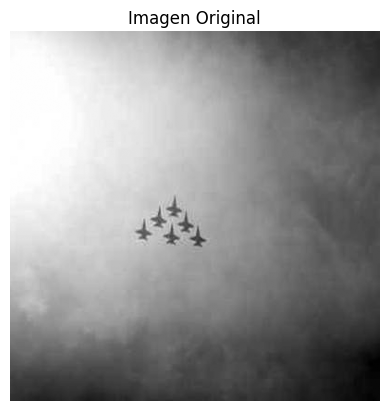

In [13]:
# === CARGAR IMAGEN EN ESCALA DE GRISES ===
img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen: {ruta_imagen}")

# === MOSTRAR LA IMAGEN ===
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Imagen Original')
plt.show()

In [14]:
# === FILTRO PROMEDIO (Lineal) ===
@njit(parallel=True)
def filtro_promedio(img, ksize=3):
    filas, columnas = img.shape
    salida = np.zeros_like(img)
    offset = ksize // 2

    for i in prange(offset, filas - offset):
        for j in range(offset, columnas - offset):
            suma = 0
            for m in range(-offset, offset + 1):
                for n in range(-offset, offset + 1):
                    suma += img[i + m, j + n]
            salida[i, j] = suma // (ksize * ksize)
    return salida

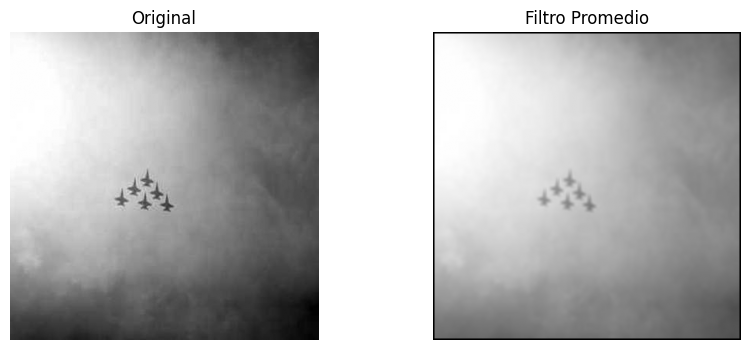

In [15]:
# === APLICAR FILTRO ===
prom = filtro_promedio(img, 5)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(prom, cmap='gray'); plt.title('Filtro Promedio'); plt.axis('off')
plt.show()
